# Binary Similarity Notebooks - MetaboLights Datasets

Nomenclature: BinSim_ML_Datasets

In this case, BinSim_ML_FC.ipynb

Datasets introduced after imports.

For the MetaboLights datasets, there isn't an 'Analysis' in the name btween BinSim and ML to separate them from the notebooks used for the dissertation.

## Warning 

This notebook performs the same analysis as BinSim_Analysis_GD11_all2_groups2all1.ipynb on a MetaboLights dataset, however it is less well organized and commented than that notebook. So, it is recommended to see one of the following notebooks first: BinSim_Analysis_GD11_all2_groups2all1.ipynb and BinSim_Analysis_YD_notnorm.

## Organization of the Notebook

- Imports and Presentation of the MetaboLights Datasets analysed in this notebook
- Reading the two filtering/alignments (Datasets from MetaboLights)
- Performing the different pre-treatments (including BinSim) on the datasets
- Preliminary analysis on the 1st alignment set of datasets
- Agglomerative Hierarchical Clustering and K-means Clustering
- Random Forest - optimization, predictive accuracy and important features
- PLS-DA - optimization, predictive accuracy and important features
- Permutation Tests

### Needed Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import itertools

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

# Python files in the repository
import scaling as sca
import multianalysis as ma

C:\Users\francisco\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%matplotlib inline

## Similarity analysis with Metabolights data: 
#### Flow Cytometry Has a Significant Impact on the Cellular Metabolome

Article link: https://pubs.acs.org/doi/10.1021/acs.jproteome.8b00472

Metabolights dataset link: https://www.ebi.ac.uk/metabolights/MTBLS629

Four groups of thioglycollate-induced peritoneal macrohpages with five biological replicates each (n = 20).
- Ctrl - peritoneal lavage pelleted cells immediately snap-frozen in liquid nitrogen upon isolation.
- Ab (Antibody) - peritoneal macrophages subjected to immunostaining and subsequently stored in liquid N2 without sorting.
- Sort - freshly isolated macrophages immediately analyzed by flow cytometry without ab labeling and with sorting of the complete cell pop. into the collection tube.
- Ab+Sort - freshly isolated cells immunostained and then sorted by flow cytometry, with collection of the complete cell population.

Metabolomics approach:
- LC–ESI–QTOF–MS methods, CE-ESI–-TOF–MS, and GC–EI-Q–MS. 
- Two reference masses 121.0509 (purine, detected m/z [C5H4N4+H]+) and 922.0098 (HP,detected m/z [C18H18O6N3P3F24+H]+).
- Obtained in ESI positive and negative modes.
- Data from LC-ESI-QTOF-MS. 

Supplementary Information has a lot of information. 

Data characteristics:
- Most of the features of the data seemed to have been filtered (like many of the Metabolights datasets that were thus not usable), however, in this case, features seemed to have been filtered with some emphasis on feature presence or not in the group of samples, generating a skewed dataset where binary measures should perform better. 

#### Probably choosing another dataset would be better

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try tosay what is happening in each block of code.

## Similarity analysis

aligned_all_neg = negative dataset or derived from the negative dataset.

aligned_all_pos = positive dataset or derived from the positive dataset.

#### Read aligned data and transformation into a DataFrame (zeros replaced as missing values)

In [3]:
file = pd.read_table('Metabolights/m_mtbls629_NEG_mass_spectrometry_v2_maf.tsv', header=[0], sep='\t')
file = file[file.columns[21:]]

labels = ["CTRL","CTRL","CTRL","CTRL","CTRL","AB","AB","AB","AB","AB",
        "SORT","SORT","SORT","SORT","SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT"]
aligned_file = mtl.add_labels(file, labels)

# Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_all_neg = aligned_file.replace({0:np.nan})

In [4]:
aligned_all_neg

label       CTRL                                                       \
       Ctrl1_neg  Ctrl2_neg     Ctrl3_neg     Ctrl4_neg     Ctrl5_neg   
0      5426183.0  5991088.0  7.717718e+06  8.612450e+06  7.203798e+06   
1        10687.0     3090.0  3.374135e+03  3.802000e+03  3.563111e+03   
2        10687.0     3090.0  3.374135e+03  3.802000e+03  3.563111e+03   
3        10687.0     3090.0  3.374135e+03  3.802000e+03  3.563111e+03   
4            NaN        NaN           NaN           NaN           NaN   
..           ...        ...           ...           ...           ...   
76      597445.0   278434.0  2.258870e+05  2.288040e+05  1.297140e+05   
77      864507.0   848432.0  8.056110e+05  6.824130e+05  9.524080e+05   
78      864507.0   848432.0  8.056110e+05  6.824130e+05  9.524080e+05   
79       99188.0    49791.0  4.991600e+04  4.903700e+04  3.696700e+04   
80      183996.0   111202.0  1.041170e+05  8.033785e+04  6.043100e+04   

label         AB                                                         SORT  \
         Ab1_neg       Ab2_neg    Ab3_neg    Ab4_neg       Ab5_neg  Sort1_neg   
0      6031306.0  7.025290e+06  5755462.0  9006708.0  8.171638e+06  2801078.0   
1            NaN  9.118000e+03        NaN        NaN           NaN        NaN   
2            NaN  9.118000e+03        NaN        NaN           NaN        NaN   
3            NaN  9.118000e+03        NaN        NaN           NaN        NaN   
4         6762.0  2.094000e+03     2094.0    41847.0  1.397771e+04     8215.0   
..           ...           ...        ...        ...           ...        ...   
76      614886.0  2.792700e+05   190702.0   121110.0  2.300600e+05   339422.0   
77     1001383.0  6.201230e+05   594368.0   594871.0  5.979400e+05   651220.0   
78     1001383.0  6.201230e+05   594368.0   594871.0  5.979400e+05   651220.0   
79       95676.0  4.853932e+04    36766.0    48299.0  4.869400e+04    46058.0   
80           NaN  1.003670e+05        NaN        NaN           NaN    89915.0   

label                                                               AB+SORT  \
          Sort2_neg     Sort3_neg     Sort4_neg     Sort5_neg  Ab+Sort1_neg   
0      5.917181e+06  1.572602e+07  3.887523e+06  5.003216e+06  5.197312e+06   
1               NaN           NaN           NaN  5.308000e+03           NaN   
2               NaN           NaN           NaN  5.308000e+03           NaN   
3               NaN           NaN           NaN  5.308000e+03           NaN   
4      2.082400e+04  8.215000e+03  1.720281e+04  2.395400e+04  1.347400e+04   
..              ...           ...           ...           ...           ...   
76     5.477400e+04  6.728600e+04  5.971300e+04  7.706000e+04  2.130780e+05   
77     6.012870e+05  5.636600e+05  3.224080e+05  3.359560e+05  5.181090e+05   
78     6.012870e+05  5.636600e+05  3.224080e+05  3.359560e+05  5.181090e+05   
79     1.647200e+04  2.838800e+04  2.027264e+04  2.659900e+04  4.272300e+04   
80     2.214710e+04  1.594368e+04  3.435000e+04  1.797101e+04  4.433542e+04   

label                                                          
       Ab+Sort2_neg  Ab+Sort3_neg  Ab+Sort4_neg  Ab+Sort5_neg  
0      5.093217e+06  2.303014e+06  1.160924e+06  2.570561e+06  
1               NaN           NaN           NaN           NaN  
2               NaN           NaN           NaN           NaN  
3               NaN           NaN           NaN           NaN  
4      2.207100e+04  1.347400e+04  1.347400e+04  1.002100e+04  
..              ...           ...           ...           ...  
76     6.466700e+04  1.054800e+05  8.045100e+04  2.133000e+04  
77     2.857124e+05  3.503950e+05  2.601550e+05  1.675570e+05  
78     2.857124e+05  3.503950e+05  2.601550e+05  1.675570e+05  
79     2.133300e+04  3.587845e+04  1.534459e+04  1.060665e+04  
80     5.126600e+04  4.175400e+04  2.821200e+04  3.967432e+04  

[81 rows x 20 columns]

In [5]:
file = pd.read_table('Metabolights/m_mtbls629_POS_mass_spectrometry_v2_maf.tsv', header=[0], sep='\t')
file = file[file.columns[21:]]

labels = ["CTRL","CTRL","CTRL","CTRL","CTRL","AB","AB","AB","AB","AB",
        "SORT","SORT","SORT","SORT","SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT","AB+SORT"]
aligned_file = mtl.add_labels(file, labels)

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_all_pos = aligned_file.replace({0:np.nan})

In [6]:
aligned_all_pos

label         CTRL                                                         AB  \
         Ctrl1_pos   Ctrl2_pos Ctrl3_pos Ctrl4_pos    Ctrl5_pos       Ab1_pos   
0              NaN         NaN       NaN       NaN          NaN           NaN   
1       15641.0000   13081.000   13222.0   10311.0    8112.0000           NaN   
2              NaN         NaN       NaN       NaN          NaN           NaN   
3              NaN         NaN       NaN       NaN          NaN           NaN   
4              NaN         NaN       NaN       NaN          NaN           NaN   
..             ...         ...       ...       ...          ...           ...   
94     133795.0000  194686.712  339793.0       NaN          NaN  2.687506e+06   
95             NaN         NaN       NaN       NaN          NaN  1.402457e+06   
96     143880.6048  119010.000  156454.0  131081.0  127030.9584  7.137470e+04   
97      16560.0000         NaN       NaN       NaN          NaN  6.657899e+04   
98     520613.0000  405177.000  432468.0  362373.0  315210.0000  4.828880e+05   

label                                                         SORT            \
         Ab2_pos    Ab3_pos       Ab4_pos       Ab5_pos  Sort1_pos Sort2_pos   
0            NaN        NaN           NaN           NaN        NaN   41559.0   
1            NaN        NaN           NaN           NaN        NaN       NaN   
2            NaN        NaN           NaN           NaN    85480.0   61826.0   
3            NaN        NaN           NaN           NaN    85480.0   61826.0   
4            NaN        NaN           NaN           NaN    85480.0   61826.0   
..           ...        ...           ...           ...        ...       ...   
94           NaN        NaN           NaN           NaN   431317.0  475497.0   
95     2106965.0  2528845.0  2.106965e+06  2.106965e+06  3843629.0       NaN   
96      139135.0   138200.0  6.207601e+04  6.332448e+04        NaN       NaN   
97       71107.0    69387.0  6.575324e+04  6.155400e+04        NaN       NaN   
98      400541.0   316450.0  3.420110e+05  3.712960e+05   286450.0  194861.0   

label                                         AB+SORT               \
      Sort3_pos     Sort4_pos Sort5_pos  Ab+Sort1_pos Ab+Sort2_pos   
0           NaN           NaN       NaN  1.276176e+06      44810.0   
1           NaN           NaN       NaN           NaN          NaN   
2       85480.0   68619.22033   84734.0  1.307660e+05          NaN   
3       85480.0   68619.22033   84734.0  1.307660e+05          NaN   
4       85480.0   68619.22033   84734.0  1.307660e+05          NaN   
..          ...           ...       ...           ...          ...   
94     380997.0  475497.00000  475497.0           NaN          NaN   
95          NaN           NaN       NaN  2.218701e+06     488612.0   
96      73651.0           NaN       NaN           NaN          NaN   
97          NaN           NaN       NaN  5.762720e+04      33811.0   
98     285086.0  193499.00000  235850.0  3.670210e+05     249374.0   

label                                            
       Ab+Sort3_pos  Ab+Sort4_pos  Ab+Sort5_pos  
0      1.734822e+06  519215.42900   26305.00000  
1               NaN           NaN           NaN  
2               NaN           NaN           NaN  
3               NaN           NaN           NaN  
4               NaN           NaN           NaN  
..              ...           ...           ...  
94              NaN           NaN  348279.00000  
95     2.300245e+05  387185.87210  266952.18380  
96              NaN           NaN           NaN  
97     6.649800e+04   42986.60956   16810.63719  
98     1.908020e+05   76095.00000   94942.00000  

[99 rows x 20 columns]

### Global metadata for consistency between tables and plots

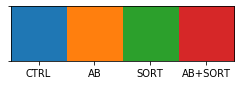

In [7]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab10', 4)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

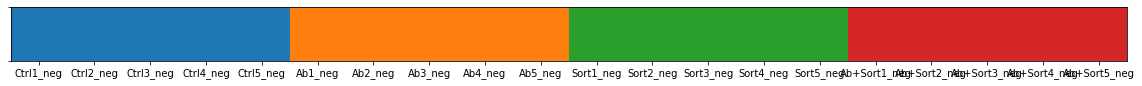

In [8]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations and pre-treatments

### Each Dataset is transformed to binary or treated by a combination of more established treatments


### Traditional Pre-Treatments

All samples need to have missing value imputation (removing features is optional). In this case, missing features were replaced with half of the minimum intensity of the full dataset.

This can be done with the `NaN_Imputation` function of scaling.py or `fillna_frac_min`(more options available) from metabolinks.

#### 3/4 types of combinations of traditional pre-treatments are made:

(Imp (Ionly) - Only Missing Value Imputation).

##### P Treatment - Missing Value Imputation and Pareto Scaling.

##### NP Treatment - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

##### NGP Treatment - Missing Value Imputation, Normalization by reference feature, Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak is removed upon normalization.

### Binary Similarity

##### BinSim - `df_to_bool` function (very simple)

### Note:

Since the state of the data we have is (partially) unknown among the different Metabolights datasets (some are known to have performed some kind of normalization, others there isn't any certainties) and since the reference features also are, for the most part, not known, normalization procedures aren't applied here as they were in the Grapevine and Yeast dataset and the "absence of treatment" (Only imputation or imputation in normalization where it was made) in the data is also tested since most of these datasets already suffered some kind of treatment.

In [9]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    #NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    #dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [10]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos)

## Preliminary Similiarity analysis

### Compute m/z similarities

In [11]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [12]:
print(sim_pos)


Sample similarity, counts of common peaks
              Ctrl1_pos  Ctrl2_pos  Ctrl3_pos  Ctrl4_pos  Ctrl5_pos  Ab1_pos  \
Ctrl1_pos            70         67         67         66         66       66   
Ctrl2_pos            67         71         70         69         69       67   
Ctrl3_pos            67         70         73         69         69       67   
Ctrl4_pos            66         69         69         69         69       65   
Ctrl5_pos            66         69         69         69         72       67   
Ab1_pos              66         67         67         65         67       80   
Ab2_pos              60         61         62         61         63       72   
Ab3_pos              61         62         63         62         64       73   
Ab4_pos              60         61         62         61         63       72   
Ab5_pos              60         61         62         61         63       72   
Sort1_pos            58         59         62         58         61       69 

In [13]:
print(sim_neg)


Sample similarity, counts of common peaks
              Ctrl1_neg  Ctrl2_neg  Ctrl3_neg  Ctrl4_neg  Ctrl5_neg  Ab1_neg  \
Ctrl1_neg            67         67         67         67         67       61   
Ctrl2_neg            67         67         67         67         67       61   
Ctrl3_neg            67         67         67         67         67       61   
Ctrl4_neg            67         67         67         68         67       61   
Ctrl5_neg            67         67         67         67         67       61   
Ab1_neg              61         61         61         61         61       64   
Ab2_neg              67         67         67         67         67       64   
Ab3_neg              63         63         63         63         63       64   
Ab4_neg              63         63         63         63         63       64   
Ab5_neg              63         63         63         64         63       64   
Sort1_neg            59         59         59         60         59       59 

### Similarity analysis (Jaccard)

Similarity fast analysis made based on the Jaccard Dissimilarities between the samples and the groups in the datasets.

Use of `mz_similarity` of metabolinks package.

In [14]:
def plot_jaccard_sims(dataset, title=''):
    "Plot heatmaps with sample and group similarity in the dataset."
    
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,
    
    # Draw Heatmaps
    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    # Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

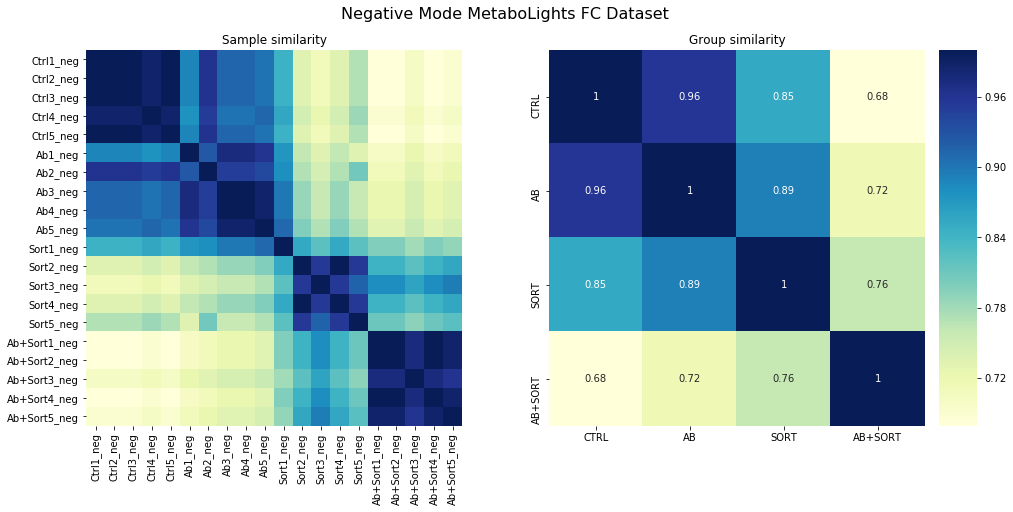

In [15]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode MetaboLights FC Dataset')

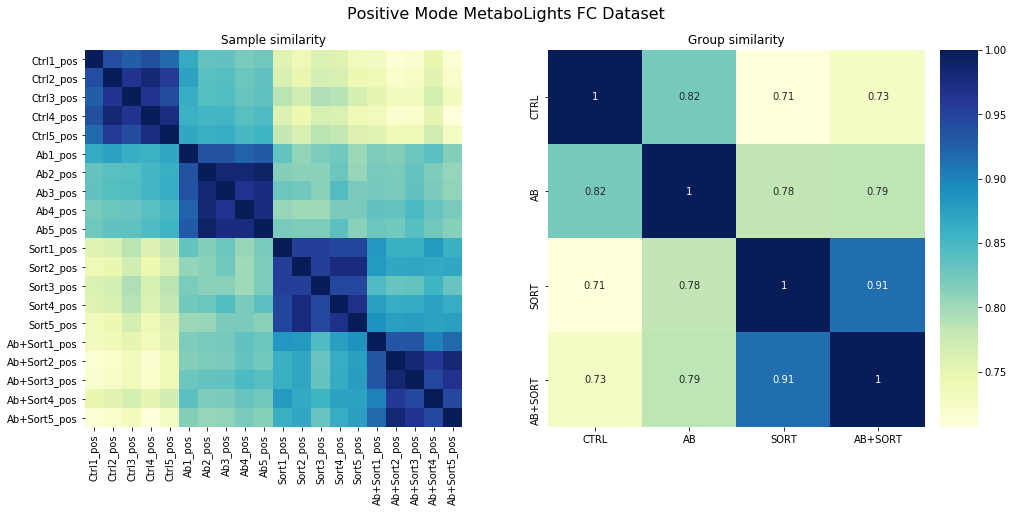

In [16]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode MetaboLights FC Dataset')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [17]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
#jsim.index.name = 'Sample'
#jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode MetaboLights FC Dataset (cophenetic = 0.96522)


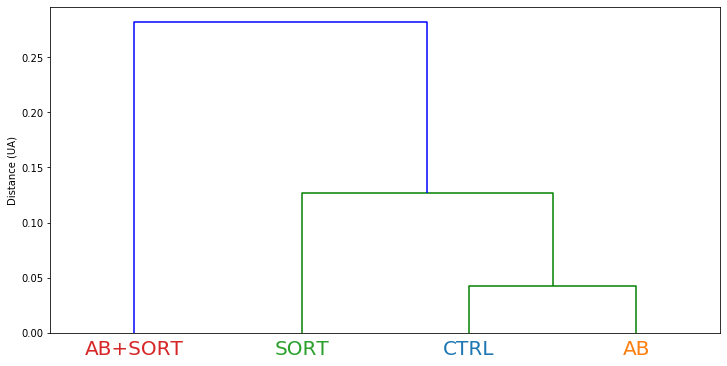

In [18]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode MetaboLights FC Dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode MetaboLights FC Dataset (cophenetic = 0.90949)


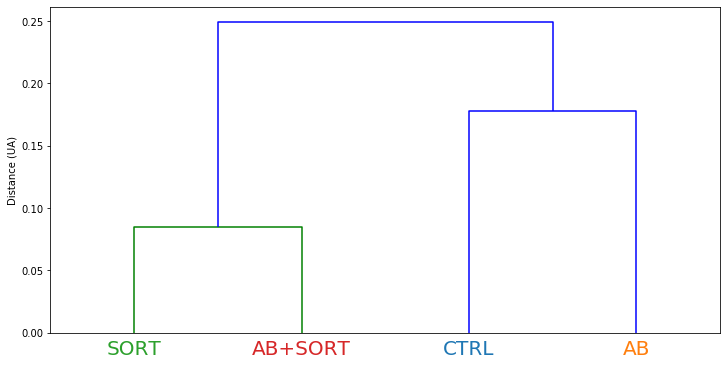

In [19]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode MetaboLights FC Dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

# Unsupervised Statistical Analysis - Both Alignments

## (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis and plotting dendrograms of each differently-treated dataset.

Dendrograms were plotted with Euclidian distance metric and UPGMA linkage for datasets treated with traditional pre-treatments.

Dendrograms were plotted with different binary distance metrics (Jaccard as example) and UPGMA linkage for datasets treated with BinSim.

In [20]:
def plot_dendogram(Z, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    plt.rcParams['lines.linewidth'] = 1.3
    
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b', leaf_rotation=45,
                         color_threshold=color_threshold)
    
    # Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

## Negative FC Dataset - ML - Dendrograms of each differently-treated dataset

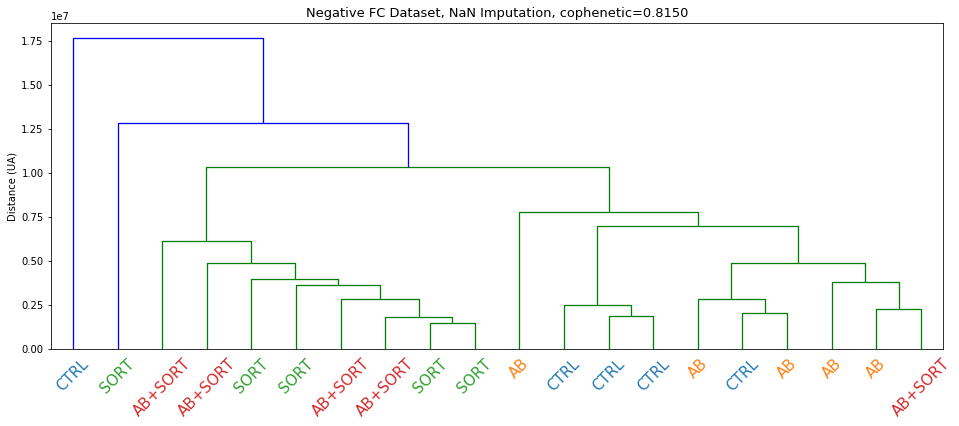

In [21]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average')

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

# Plot the dendrogram
title = f'Negative FC Dataset, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

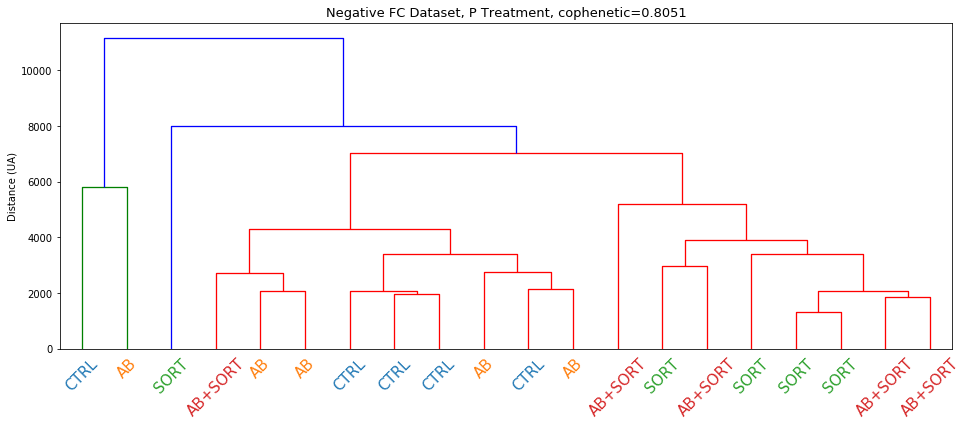

In [22]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average')  #ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0]

# Plot the dendrogram
title = f'Negative FC Dataset, P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

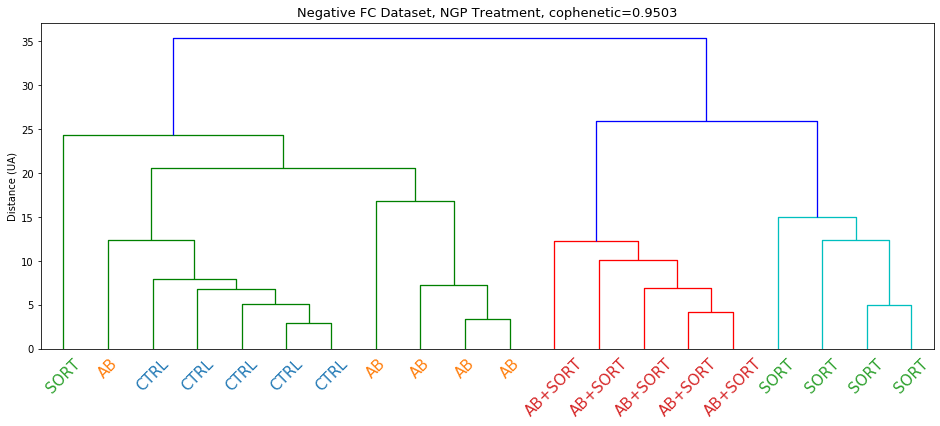

In [23]:
# Imputed, glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0]

# Plot the dendrogram
title = f'Negative FC Dataset, NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity 

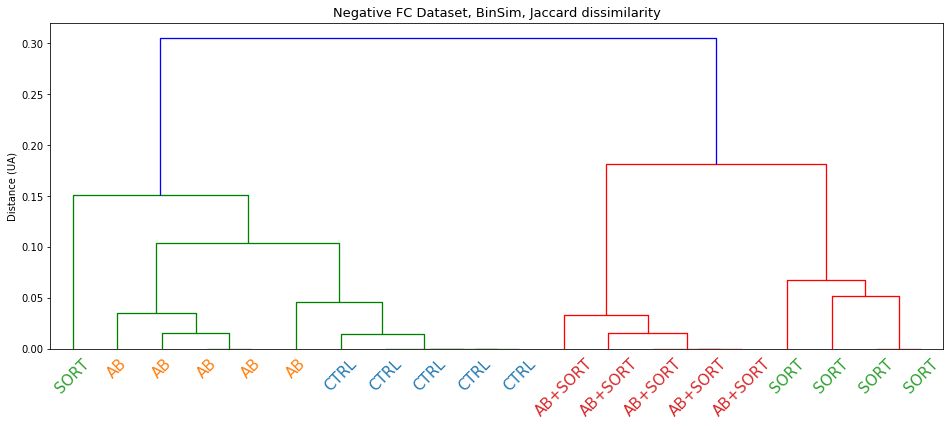

In [24]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Build the linkage matrix of the HCA
Zdice = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Negative FC Dataset, BinSim, Jaccard dissimilarity'
plot_dendogram(Zdice, title)

### Positive Mode - Dendograms with each differently-treated Grapevine Dataset

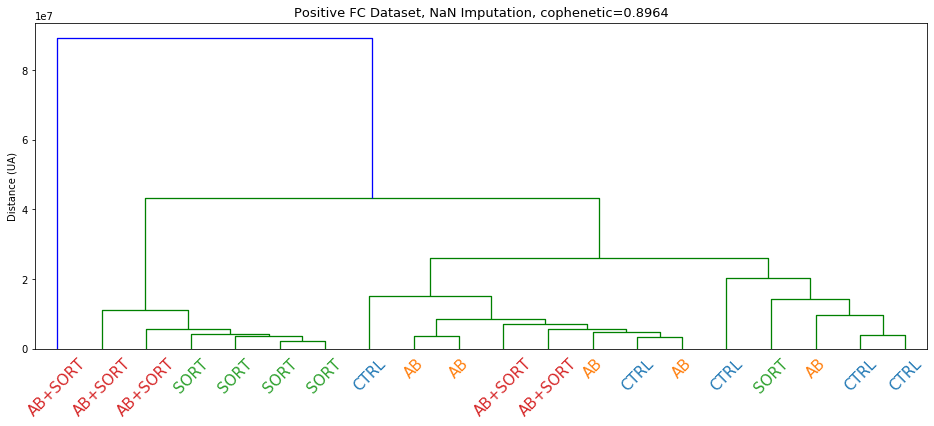

In [25]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

# Plot the dendrogram
title = f'Positive FC Dataset, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos, title)

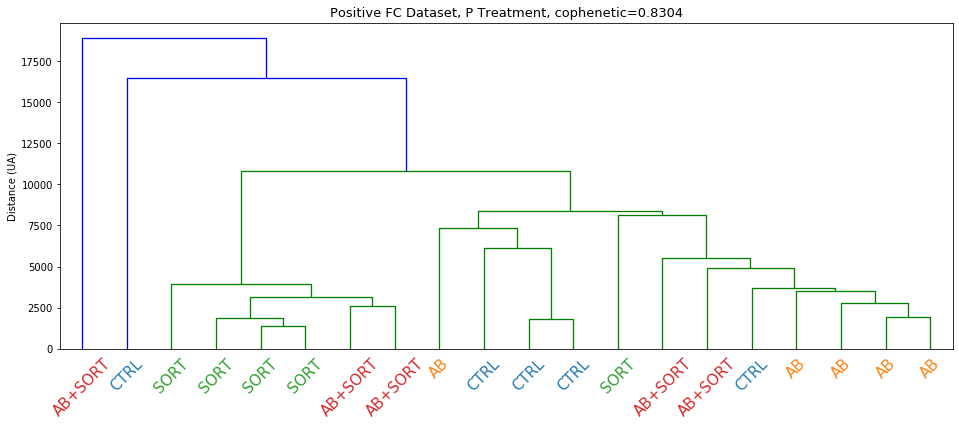

In [26]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0]

# Plot the dendrogram
title = f'Positive FC Dataset, P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

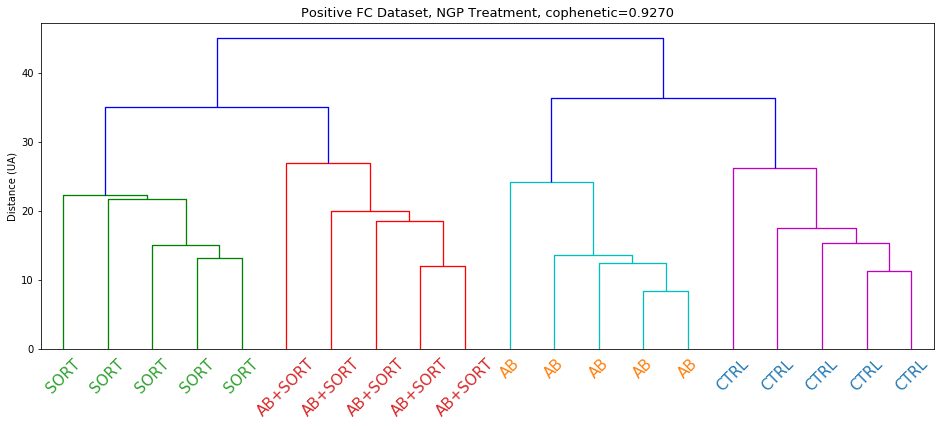

In [27]:
# Imputed, glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] 

# Plot the dendrogram
title = f'Positive FC Dataset, NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity 

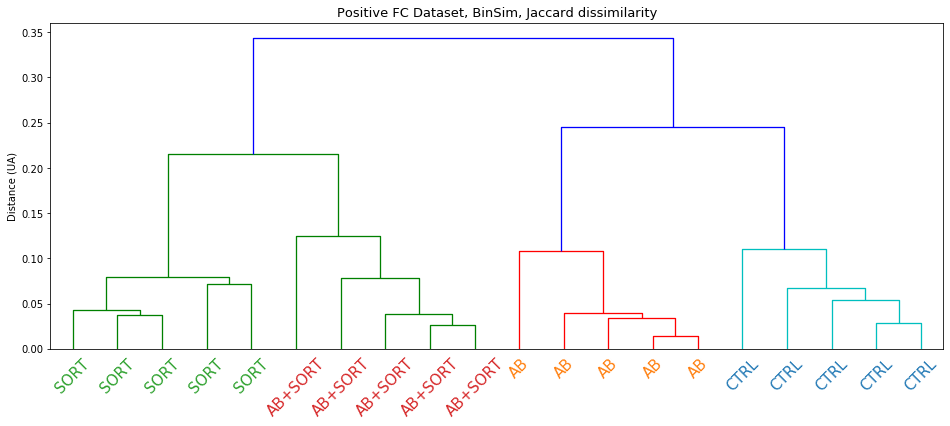

In [28]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Zdice = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Positive FC Dataset, BinSim, Jaccard dissimilarity'
plot_dendogram(Zdice, title)

### Similarity Comparison of the dendrograms made with all binary distance metrics and euclidean distances from the differently-treated datasets

#### Two methods: Cophenetic Correlation Coefficient and Baker's Gamma Correlation Coefficient

Baker's Gamma Correlation: Use of the `mergerank` function from multianalysis.py to create a 'rank' of the iteration number two samples were linked to the same cluster. Then see Kendall Correlation between the results from 2 dendrograms according to Baker's paper (Spearman Correlation according to R package 'dendextend').

Correlation Cophenetic Correlation: Pearson Correlation of the matrix of cophenetic distances of two different dendrograms.

### Traditionally-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

In [29]:
Est_Treat_Z = (Z_Imp_neg, Z_P_neg, Z_NGP_neg, Z_Imp_pos, Z_P_pos, Z_NGP_pos)
dist_Est_Treat = (dist_Imp_neg, dist_P_neg, dist_NGP_neg, dist_Imp_pos, dist_P_pos, dist_NGP_pos)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(Est_Treat_Z, dist_Est_Treat)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0s 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples of procedure with these methods

#### Cophenetic Correlation Coefficient

In [30]:
# Apply np.corrcoef since cophenet function returns elements in the same order
print('Pair of samples      \tPearson Correlation \tp-value')
print('Imp Treat-P Treat\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Imp Treat-NGP Treat\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Imp Treat-P Treat	 0.8106713672741706 	 1.4109515235550026e-45
Imp Treat-NGP Treat	 0.24891233762558337 	 0.0005340970900527171


#### Baker's Gamma Correlation Coefficient

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [31]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Imp Treat-P Treat\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Imp Treat-NGP Treat\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Imp Treat-P Treat	 0.7626064346026121 	 5.126960001431431e-80
Imp Treat-NGP Treat	 0.25475650029201113 	 5.914504997200474e-10


According to the explanation given in the R package dendextend

In [32]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Imp Treat-P Treat\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Imp Treat-NGP Treat\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Imp Treat-P Treat	 0.8415262981524682 	 3.961947697762646e-103
Imp Treat-NGP Treat	 0.3149480835303895 	 3.3908514692383237e-10


### BinSim-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

Also building linkage matrices (HCA) using all different binary distance metrics.

Change between number of binary metrics to use.

In [33]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
#binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
binary = ( 'jaccard', 'hamming', 'yule')

In [34]:
bin_neg = treat_neg['binary']
bin_pos = treat_pos['binary']

In [35]:
# Application of all "single" steps needed presented in the examples above with every distance metric.
# Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(bin_neg.T, metric = binary[i], method='average')) # Z
    K_neg.append(ma.mergerank(Z_neg[i])) # Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) # Eliminating 0s
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(bin_neg.T, metric = binary[i]))) # Cophenetic

In [36]:
# Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(bin_pos.T, metric = binary[i], method='average')) # Z
    K_pos.append(ma.mergerank(Z_pos[i])) # Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) # Eliminating 0s
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(bin_pos.T, metric = binary[i]))) # Cophenetic

### Calculating the correlation between the dendrograms - Last step, calculate each pairwise correlation

Choose what set of linkage matrices (one for each differently-treated dataset) to consider when calculating similarity between them (only 3 different binary distance metrics).

In [37]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
# 3 combination of traditional pre-treatments (Euclidian Distance) + 
# 3 different binary distance metrics (for BinSim treated datasets) for each of the datasets
S = S_BG + S_neg + S_pos

# Creation of a list with all the returns from the function cophenetic for the different metrics: 
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values for all three methods

In [38]:
#Column names and row names for the dataframes
colnames = ['Imp_neg', 'P_neg', 'NGP_neg', 'Imp_pos', 'P_pos', 'NGP_pos',
            'Jaccard_neg', 'Hamming_neg', 'Yule_neg', 'Jaccard_pos', 'Hamming_pos', 'Yule_pos']

In [39]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

# Calculation of correlation coefficient for each method
for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [40]:
# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,6:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:6], line, df.iloc[6:]])
    prep = pd.concat([prep.iloc[:,:6], lineV.T, prep.iloc[:,6:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: DataProcessing_Mode; Last 6: BinaryMetric_Mode


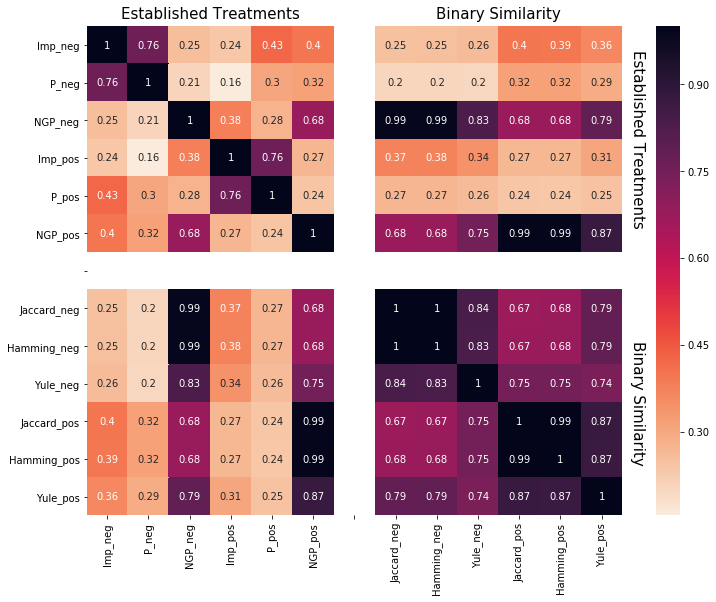

In [41]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Established Treatments', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Established Treatments', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binary Similarity', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binary Similarity', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: DataProcessing_Mode; Last 6: BinaryMetric_Mode


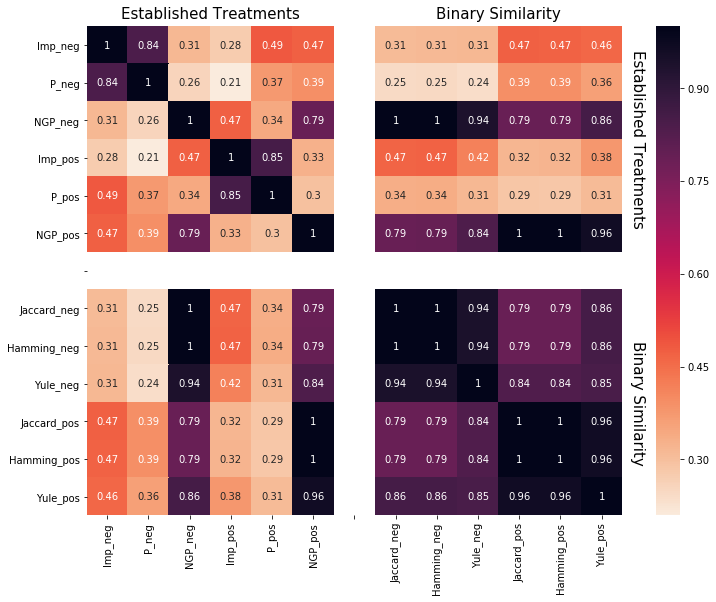

In [42]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Established Treatments', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Established Treatments', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binary Similarity', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binary Similarity', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: DataProcessing_Mode; Last 6: BinaryMetric_Mode


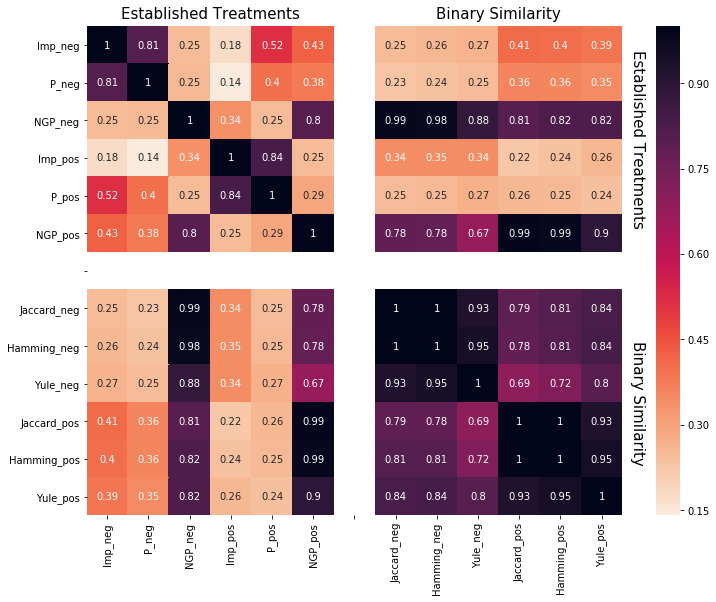

In [43]:
f, ax = plt.subplots(figsize=(12, 9))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Established Treatments', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Established Treatments', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binary Similarity', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binary Similarity', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Different colours for the Negative treated traditionally, Positive treated traditionally, Negative treated with BinSim (different binary distance metrics) and Positive treated with BinSim (different binary distance metrics).

In [44]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: DataProcessing_Mode; or BinaryMetric_Mode


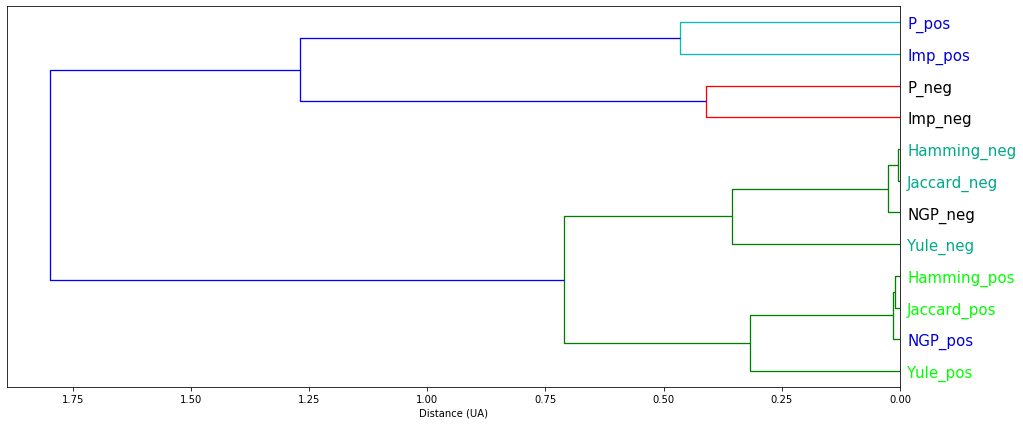

In [45]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: DataProcessing_Mode; or BinaryMetric_Mode')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=correlations['K'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: DataProcessing_Mode; or BinaryMetric_Mode


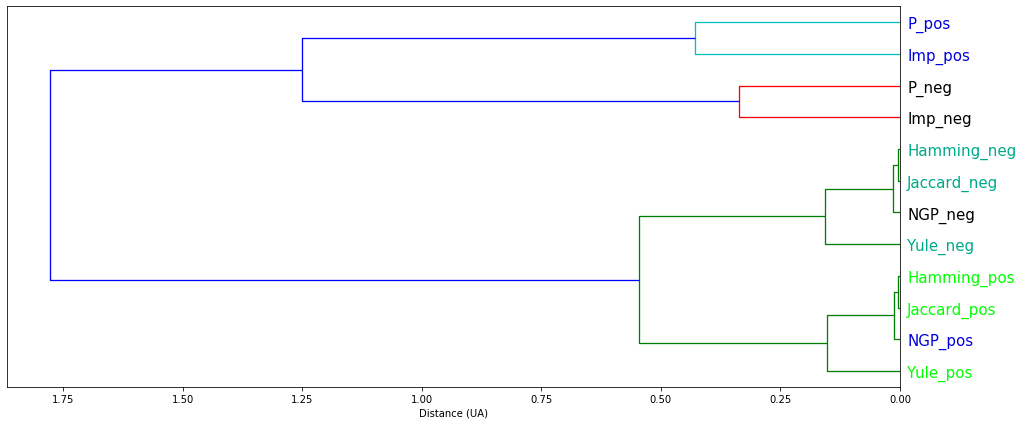

In [46]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: DataProcessing_Mode; or BinaryMetric_Mode')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=correlations['S'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: DataProcessing_Mode; or BinaryMetric_Mode


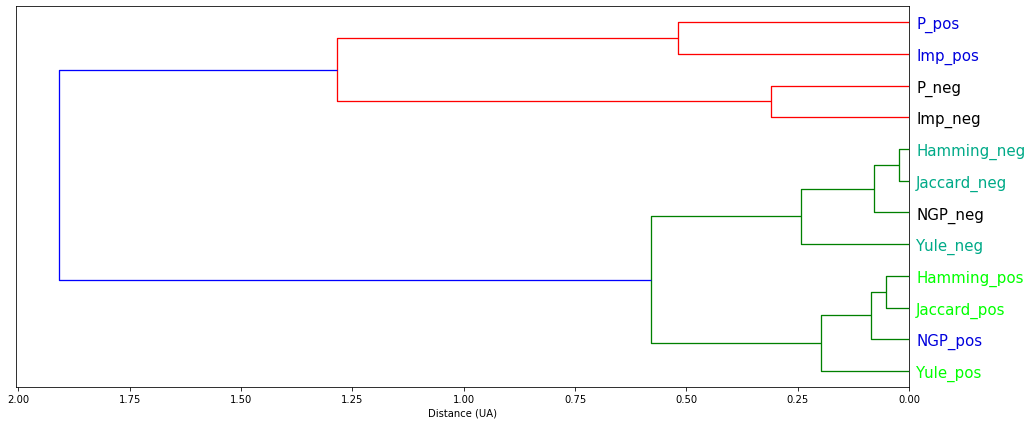

In [47]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: DataProcessing_Mode; or BinaryMetric_Mode')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=correlations['C'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Comparing HCAs (Dendrograms) Discrimination

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [48]:
# Preparing Z linkage matrices
Z = []
Z.extend(Est_Treat_Z)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [49]:
disc_average = np.zeros((1,12)) # Discrimination Distance Storing
disc_correct = np.zeros((1,12)) # Correct Clustering Percentage Storing
disc_1stclust = np.zeros((1,12)) # Correct First Cluster Percentage Storing

for i in range(len(Z)):
    data = aligned_all_pos
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    #disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] # all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.correct_1stcluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 4, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames) # Transforming into %s

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)
disc_1stclust = pd.concat([disc_1stclust.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct 1st cluster']).T, disc_1stclust.iloc[:,6:]], axis = 1)

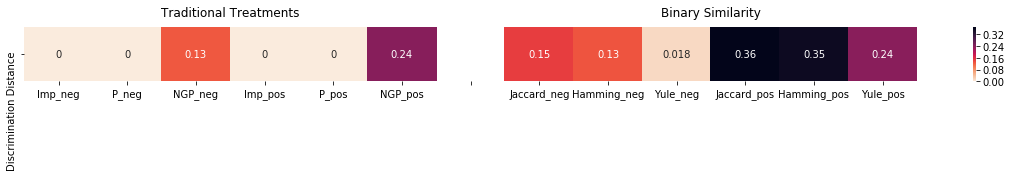

In [50]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'Traditional Treatments', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'Binary Similarity', fontsize = 12, horizontalalignment='center')
plt.show()

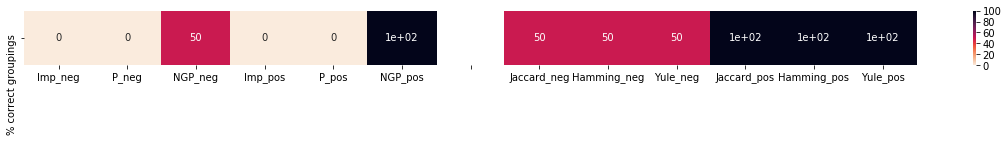

In [51]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

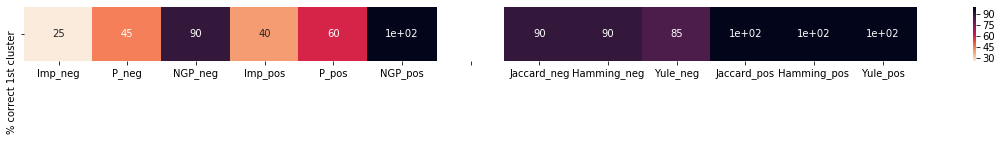

In [52]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_1stclust, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [53]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

In [54]:
Kmean = skclust.KMeans(n_clusters=4)

In [55]:
a = Kmean.fit(NGP_neg.T)
a.inertia_

1264.2013216170888

In [56]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{3: ['CTRL', 'CTRL', 'CTRL', 'CTRL', 'CTRL', 'AB'],
 0: ['AB', 'AB', 'AB', 'AB', 'SORT'],
 2: ['SORT', 'SORT', 'SORT', 'SORT'],
 1: ['AB+SORT', 'AB+SORT', 'AB+SORT', 'AB+SORT', 'AB+SORT']}

Adjusted Rand Index

In [57]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_neg.cdl.labels
adjusted_rand_score(NGP_neg.cdl.labels,a.labels_)

0.7332782824112304

### K-means clustering applied to all euclidean methods and the binary matrixes built

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group (stricter definition than in HCA).

A method similar to the Discrimination Distance and Correct Clustering percentage performed in the HCA was made. Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero and the groups isn't correctly clustered. Therefore, this method is harsher than the Discrimination Distance and Correct Clustering Percentage for HCA.  Thus, the Correct Clustering Percentage is expected to be lower in this case

The Discrimination Distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. It is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean of the Discrimination Distances of all groups is then a measure of the global Discrimination Distance. 

In [58]:
colnames2 = ['Imp_neg', 'P_neg', 'NGP_neg', 'BinSim_neg',
             'Imp_pos', 'P_pos', 'NGP_pos', 'BinSim_pos']

In [59]:
Data = (Imp_neg, P_neg, NGP_neg,  bin_neg, Imp_pos, P_pos, NGP_pos, bin_pos)

In [60]:
disc_average = np.zeros((1,8))
disc_median = np.zeros((1,8))
disc_correct = np.zeros((1,8))
disc_rand = np.zeros((1,8))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct/4*100, index = ['% correct groupings'], columns = colnames2)
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames2)

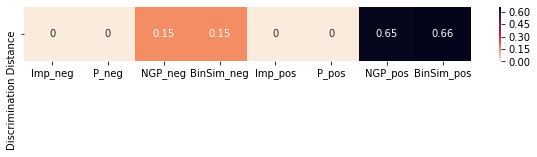

In [61]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

In [62]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

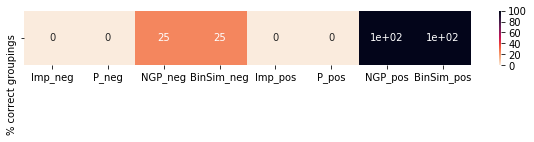

In [63]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

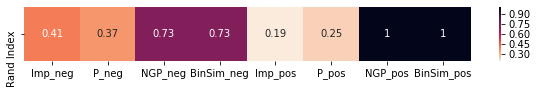

In [64]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis - Balanced dataset

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA. The performance of the models/classifiers built will be evaluated by their predictive accuracy - estimated by internal stratified (as possible) 5-fold cross-validation).

Internal stratified 5-fold cross-validation was used to estimate the model's performance since that is maximum number possible since the smaller group of samples has 5 replicates in the dataset.

In [65]:
# Centralize data information in a dictionary
datasets = {}

datasets['Imp_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['BinSim_neg'] = treat_neg['binary']

datasets['Imp_pos'] = treat_pos['Ionly']
datasets['P_pos'] = treat_pos['P']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['BinSim_pos'] = treat_pos['binary']

## Random Forests

### Test number of trees needed for predictive accuracy convergence for N, NP, NGP and BinSim treated data

Random Forest models with different number of trees will be built to assess when the predictive accuracy of the different models stops increasing with higher number of trees.

Grid search of number of trees from 10 to 450 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes some time

In [66]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,450,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 5)

In [67]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting Imp_neg ... Done!
Fitting P_neg ... Done!
Fitting NGP_neg ... Done!
Fitting BinSim_neg ... Done!
Fitting Imp_pos ... Done!
Fitting P_pos ... Done!
Fitting NGP_pos ... Done!
Fitting BinSim_pos ... Done!


Performance based on number of trees - Negative Mode


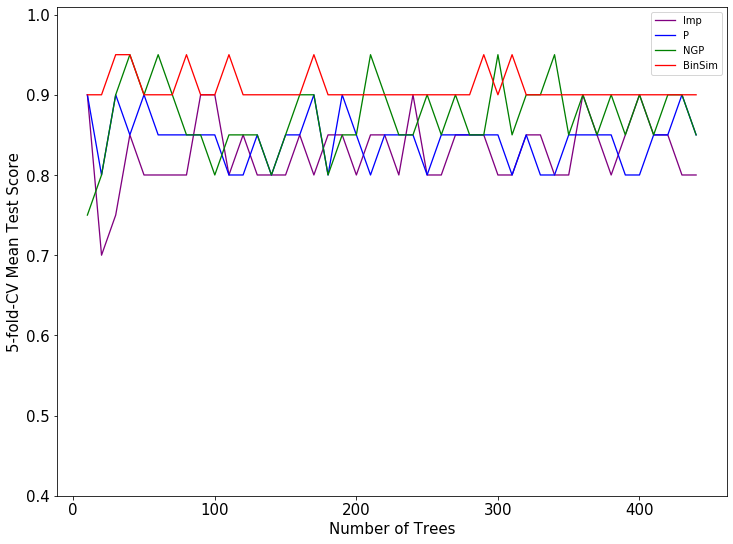

In [68]:
f, ax = plt.subplots(figsize=(12,9))
color = ['purple','blue','green','red']*2
for i in range(0,4):
    plt.plot(param[i], test_score[i], color = color[i])
plt.ylabel('5-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'BinSim'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Negative Mode')

Performance based on number of trees - Positive Mode


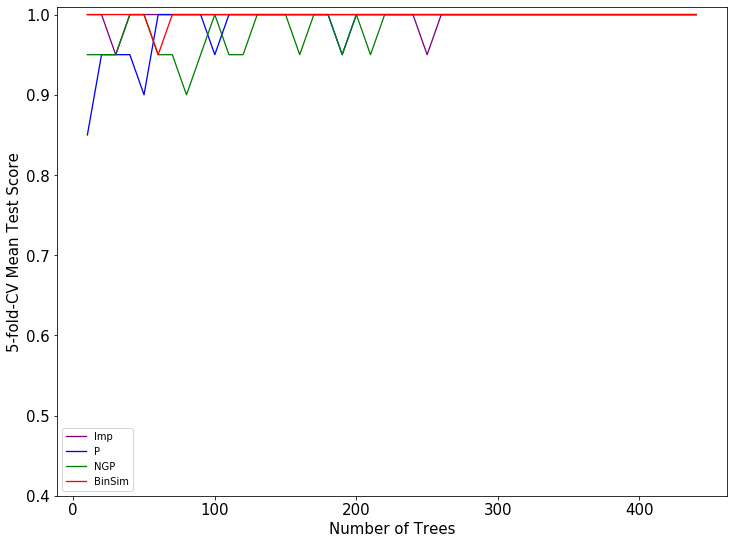

In [69]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(4,8):
    plt.plot(param[i], test_score[i], color = color[i])
plt.ylabel('5-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'BinSim'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Positive Mode')

### Random Forest Application

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn (all estimated by stratified 5-fold cross-validation) of each of the iterations (with different samplings of the 5 folds) of models built for each secondary dataset.

Iterations are made to randomly sample the folds in 5-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset. The number of folds used will be the one that seems most appropriate in each case. For balanced datasets n_fold = number of replicates in each group if the number of replicates is under 10.

Use of the `simple_RF` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.

In [70]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [71]:
# Application of the Random Forests for each differently-treated dataset
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, n_fold = 5) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for Imp_neg ...done
Fitting random forest for P_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for BinSim_neg ...done
Fitting random forest for Imp_pos ...done
Fitting random forest for P_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for BinSim_pos ...done


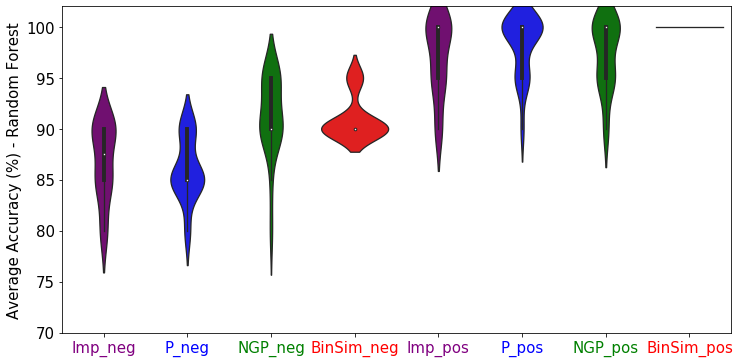

In [72]:
# Violin plot of the distribution of the predictive accuracy (in %) across the iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(12,6))

data = pd.DataFrame.from_dict(Teste) * 100

colors = ['purple','blue','green','red']*2
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Average Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([70,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

In [73]:
# Average prediction accuracy of the models built for each of the
# differently-treated datasets estimated by stratified 5-fold cross validation
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.mean(Teste[i])

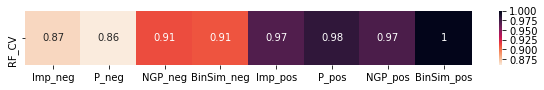

In [74]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])

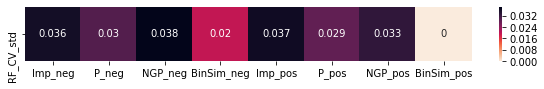

In [75]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [76]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

In [77]:
#sns.set_context('notebook')

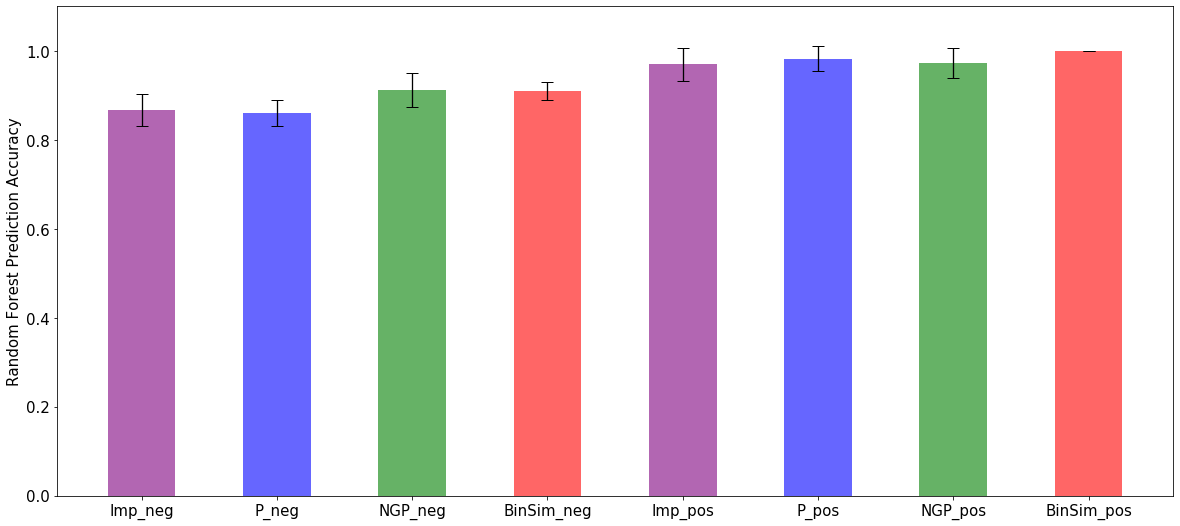

In [78]:
f, ax = plt.subplots(figsize=(20, 9))
#sns.set_context('talk')
color = ['purple','blue','green','red']
plt.bar(height = Teste_H.T['Accuracy'], x = Teste_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns, y = Teste_H.T['Accuracy'], yerr = Teste_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Characteristics of the features considered as important in the differently-treated dataset

We take the 2% most important features in each case and calculate the median number of samples those features appear (samples_m), the median number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). 

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

We also see how many times the importance of the most important feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('explained').

In [79]:
# Getting the number of samples, groups, ratios for each important feature, 
# magnitude for most important feature and calculating % explained by these features (explained)
ev = []
magni = []
explained = []
for name in Teste_feat:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    
    # Important Features
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    # Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    explained.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [80]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'ev'
for i in range(len(ev)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev[i].iloc[:,0]))
    groups_m.append(np.median(ev[i].iloc[:,1]))
    ratio_m.append(np.median(ev[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = [i  for i in Teste_feat])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"Sample Nº": None, "Group nº": None, 'Ratio':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

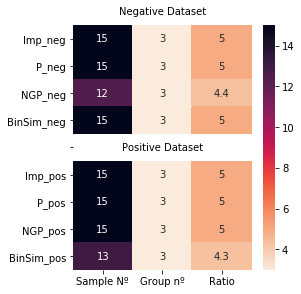

In [81]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset',horizontalalignment='center', verticalalignment='center')
plt.show()

Distribution of number of samples important features of Random Forest models appear in


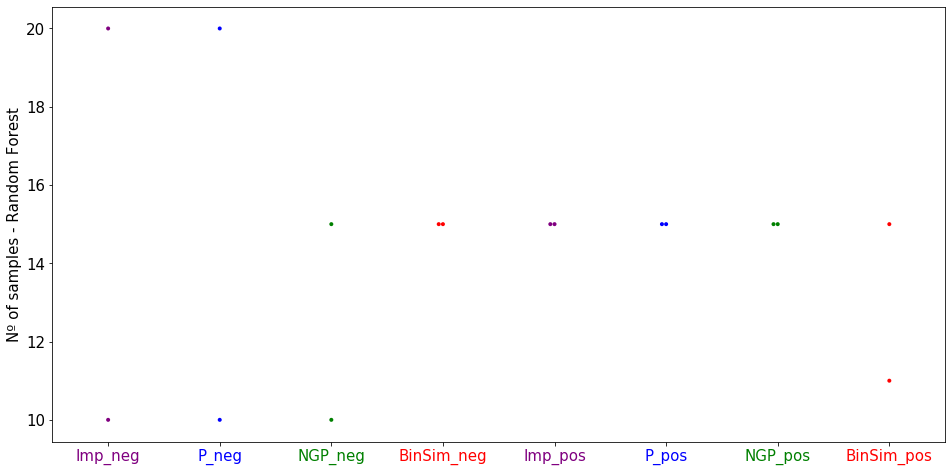

In [82]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(16,8))
data = [ev[i]['nsamples'] for i in range(8)] #range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))])
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - Random Forest', fontsize = 15)
colors = ['purple','blue','green','red']*2
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Distribution of number of samples important features of Random Forest models appear in')
plt.show()

In [83]:
print('Magnitude of most important feature:', )
for i in range(8):
    print(list(Teste_feat.keys())[i], '   \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(8):
    print(list(Teste_feat.keys())[i], '  \t', explained[i])

Magnitude of most important feature:
Imp_neg    	 1.791218171449617
P_neg    	 1.8149325207481664
NGP_neg    	 1.8250148071954186
BinSim_neg    	 5.772062158044561
Imp_pos    	 2.4567428860126808
P_pos    	 2.465063156384096
NGP_pos    	 2.415000470199512
BinSim_pos    	 3.5702589631122073


% of model explained by the 2% most important features
Imp_neg   	 4.322477962714509
P_neg   	 4.227971726787194
NGP_neg   	 4.239600685266627
BinSim_neg   	 14.173729032745797
Imp_pos   	 4.870959251557322
P_pos   	 4.977053650048241
NGP_pos   	 4.821344560884534
BinSim_pos   	 6.891229767106948


## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. 

### Optimization - Search for the best number of components to use

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

Strategy: Perform PLS-DA with different number of components and observe the score (given directly by the method score, inverse relation to the mean-squared error (MSE)) of the models built estimated with stratified 5-fold cross-validation. Then plot the different results obtained and see at which point (number of components) the score starts approaching a "stable maximum value".

To observe details of the `optim_PLS` function - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp - see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [84]:
PLS_optim = {}

In [85]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 10, n_fold = 5)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for Imp_neg ...done
Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for BinSim_neg ...done
Optimizing PLS-DA for Imp_pos ...done
Optimizing PLS-DA for P_pos ...done
Optimizing PLS-DA for NGP_pos ...done
Optimizing PLS-DA for BinSim_pos ...done


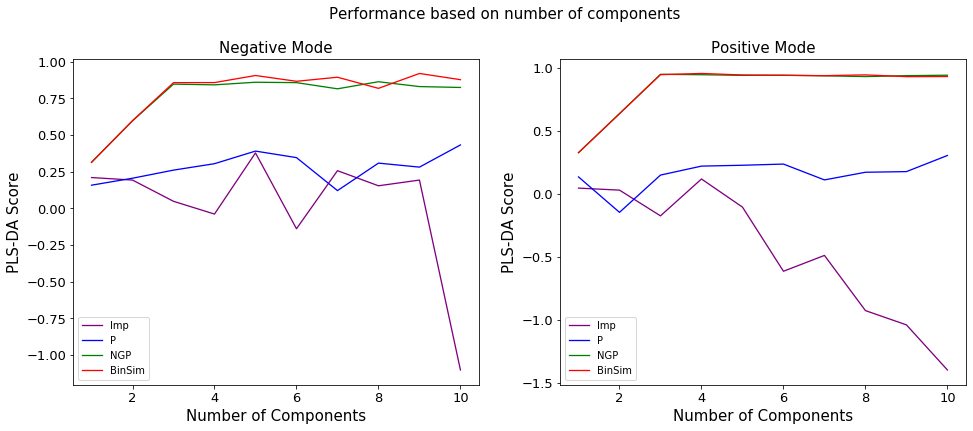

In [86]:
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 1)
color = ['purple','blue','green','red']*2
i = 0

for name, data in PLS_optim.items():
    if name.endswith('neg'):
        # Negative
        quadrant[0].plot(range(1,11),data, color[i])
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('Negative Mode', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('Imp', 'P', 'NGP', 'BinSim'))
    
    if name.endswith('pos'):
        # Positive
        quadrant[1].plot(range(1,11),data, color[i])
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('Positive Mode', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('Imp', 'P', 'NGP', 'BinSim'))
    i = i+1

### Application of PLS-DA

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule. Models were evaluated according to their predictive accuracy estimated by 5-fold cross-validation.

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [87]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [88]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 3, iter_num = 100, n_fold = 5, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for Imp_neg ...done
Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for BinSim_neg ...done
Fitting PLS-DA for Imp_pos ...done
Fitting PLS-DA for P_pos ...done
Fitting PLS-DA for NGP_pos ...done
Fitting PLS-DA for BinSim_pos ...done


Predictive Accuracy of PLS-DA models - FC Datasets


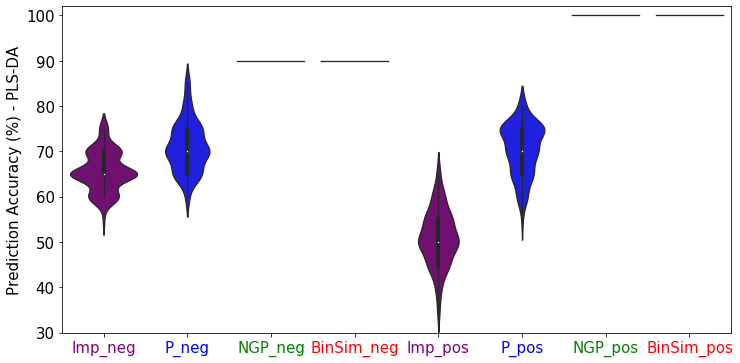

In [89]:
# Plot the distribution of prediction accuracy of the 200 iterations of models built from the differently-treated datasets
# Adjust Parameters
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']*2
data=pd.DataFrame.from_dict(PLS_accu) * 100
sns.violinplot(data=data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([30,102])
ax.tick_params(axis='x', which='major', labelsize= 15)
ax.tick_params(axis='y', which='major', labelsize= 15)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Predictive Accuracy of PLS-DA models - FC Datasets')
plt.show()

### Accuracies Summary

In [90]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

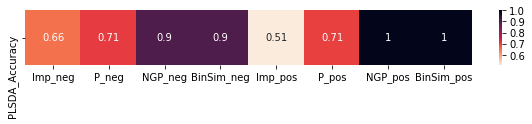

In [91]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.show()

In [92]:
#Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T

#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [93]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
Imp_neg,0.6570,4.243819e-02
P_neg,0.7105,5.490674e-02
NGP_neg,0.9000,4.440892e-16
BinSim_neg,0.9000,4.440892e-16
Imp_pos,0.5100,6.082763e-02
P_pos,0.7055,5.607807e-02
NGP_pos,1.0000,0.000000e+00
BinSim_pos,1.0000,0.000000e+00


### Characteristics of the features considered as important in the differently-treated datasets 

Same process as applied for Random Forest.

In [94]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev_PLS = []
magni = []
index = []

for name in PLS_feat:
    if name.endswith('neg'):
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        Spectra = aligned_all_pos
    
    # Important Features
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    # Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev_PLS.append(df)

In [95]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'ev_PLS'
for i in range(len(ev_PLS)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev_PLS[i].iloc[:,0]))
    groups_m.append(np.median(ev_PLS[i].iloc[:,1]))
    ratio_m.append(np.median(ev_PLS[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = [i  for i in PLS_feat])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m
#print(df)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"Sample Nº": None, "Group nº": None, 'Ratio':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8]])

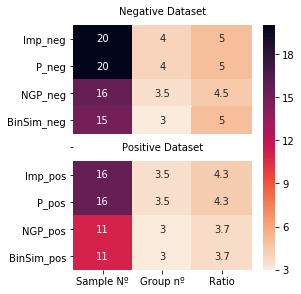

In [96]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 1)
plt.text(1.5,-0.5,'Negative Dataset',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset',horizontalalignment='center', verticalalignment='center')
plt.show()

Distribution of number of samples important features of PLS-DA models appear in


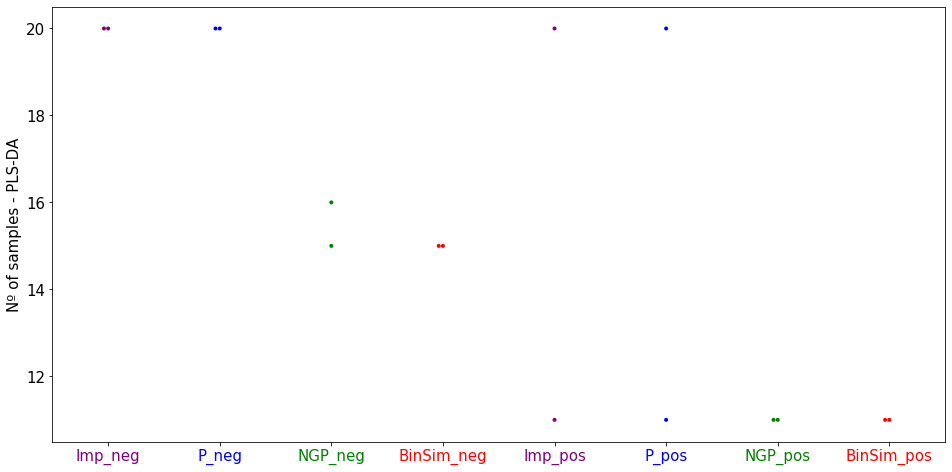

In [97]:
# Plot the swarm plot and adjust parameters
f, ax = plt.subplots(figsize=(16,8))
data = [ev_PLS[i]['nsamples'] for i in range(len(ev_PLS))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.ylabel('Nº of samples - PLS-DA', fontsize = 15)
colors = ['purple','blue','green','red']*2
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

print('Distribution of number of samples important features of PLS-DA models appear in')
plt.show()

In [98]:
print('Magnitude of most important features for each case:')
for i in range(8):
    print(list(PLS_feat.keys())[i], '   \t', magni[i])

Magnitude of most important features for each case:
Imp_neg    	 8.064936923486721
P_neg    	 6.39619835043944
NGP_neg    	 3.5560401625700764
BinSim_neg    	 4.221795101836905
Imp_pos    	 12.121747519177811
P_pos    	 6.601780179751006
NGP_pos    	 3.7820326668908355
BinSim_pos    	 4.342374908401909


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [99]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP data treatment for the Negative Mode

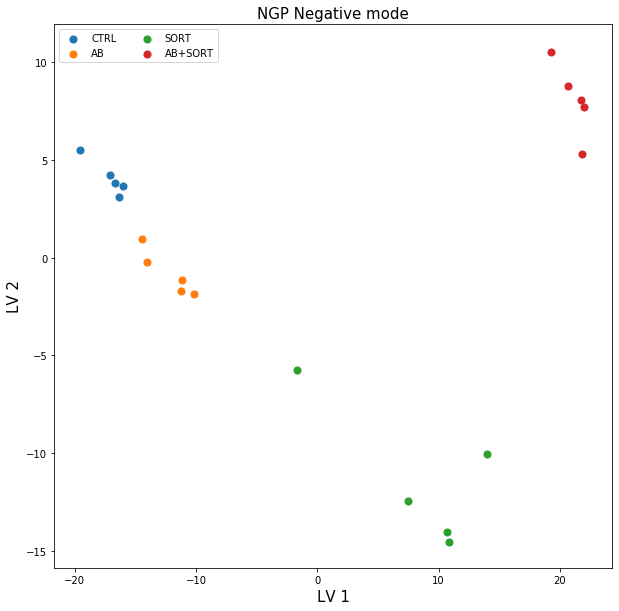

In [100]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### BinSim processed data for the negative mode

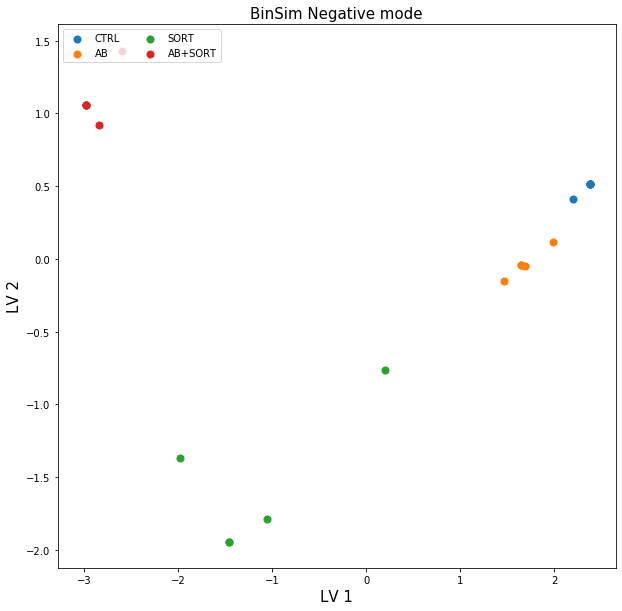

In [101]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(bin_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### NGP data treatment for the Positive Mode

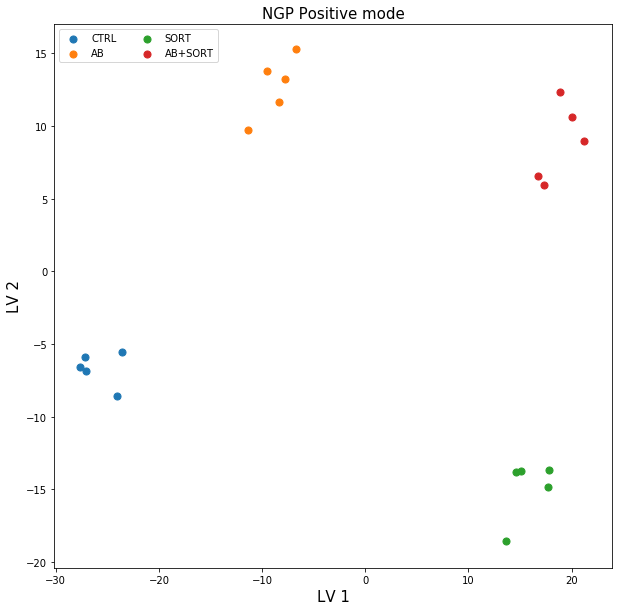

In [102]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(NGP_pos, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Positive mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### BinSim processed data for the positive mode

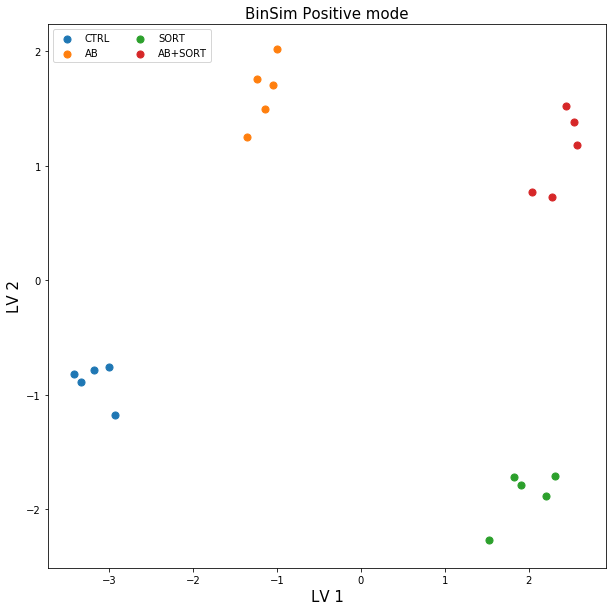

In [103]:
n_components = 4

plsreg_GPneg = ma.PLSscores_with_labels(bin_pos, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Positive mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

## Permutation Tests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 1000 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random k-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests (very slow)

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [104]:
CV = {}
PMs = {}
pvalue = {}

In [105]:
all_data = (Imp_neg, P_neg, NGP_neg, bin_neg, Imp_pos, P_pos, NGP_pos, bin_pos)
names = ('Imp_neg', 'P_neg', 'NGP_neg', 'BinSim_neg', 'Imp_pos', 'P_pos', 'NGP_pos', 'BinSim_pos')

# Application of permutations tests
for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=5)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Imp_neg ...
Done!
Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for BinSim_neg ...
Done!
Permutation test (Random Forest) for Imp_pos ...
Done!
Permutation test (Random Forest) for P_pos ...
Done!
Permutation test (Random Forest) for NGP_pos ...
Done!
Permutation test (Random Forest) for BinSim_pos ...
Done!


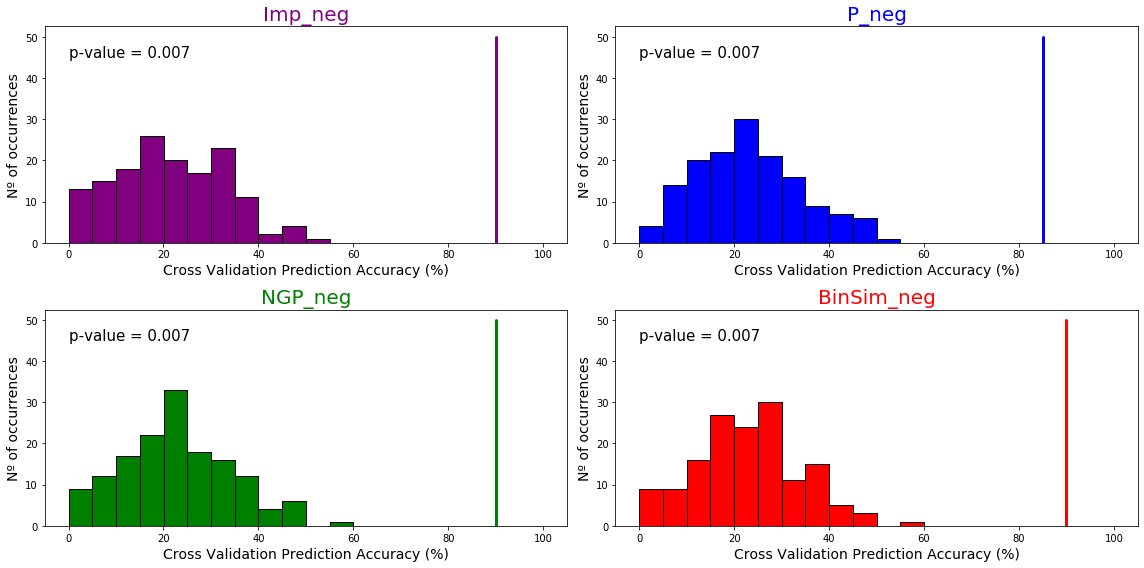

In [106]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'BinSim_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

# Setting paramaters
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(0,45, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

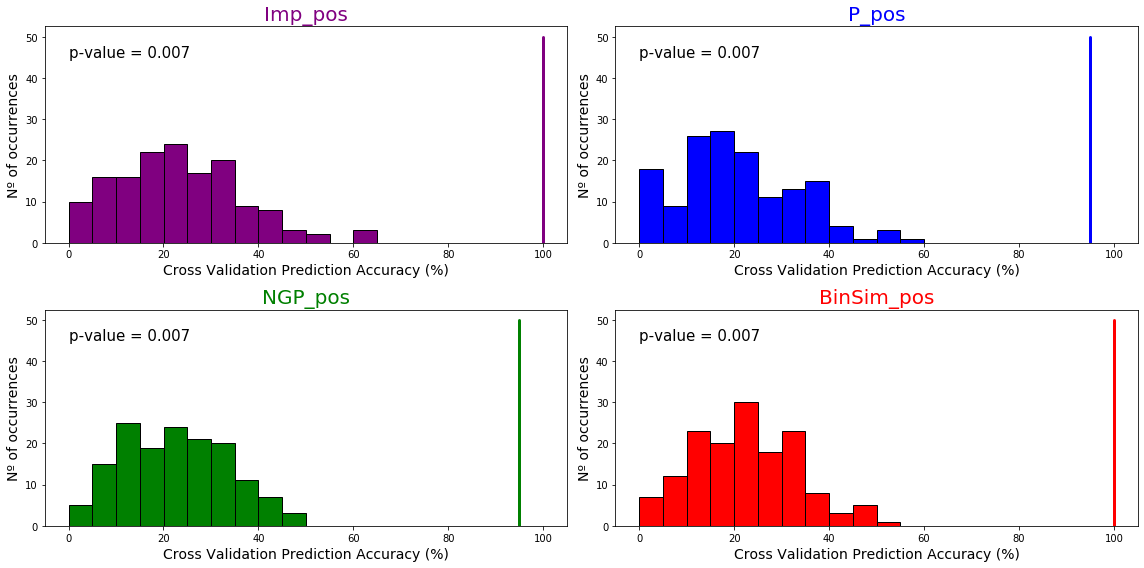

In [107]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_pos', 'P_pos', 'NGP_pos', 'BinSim_pos']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos.cdl.labels)

# Setting paramaters
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(0,45, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

### Permutation Tests - PLS-DA (slow)

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [108]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [109]:
all_data = (Imp_neg, P_neg, NGP_neg, bin_neg, Imp_pos, P_pos, NGP_pos, bin_pos)
names = ('Imp_neg', 'P_neg', 'NGP_neg', 'BinSim_neg', 'Imp_pos', 'P_pos', 'NGP_pos', 'BinSim_pos')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp = 4, iter_num = 150, n_fold = 5)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Imp_neg ...
Done!
permutation test (PLS-DA) for P_neg ...
Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for BinSim_neg ...
Done!
permutation test (PLS-DA) for Imp_pos ...
Done!
permutation test (PLS-DA) for P_pos ...
Done!
permutation test (PLS-DA) for NGP_pos ...
Done!
permutation test (PLS-DA) for BinSim_pos ...
Done!


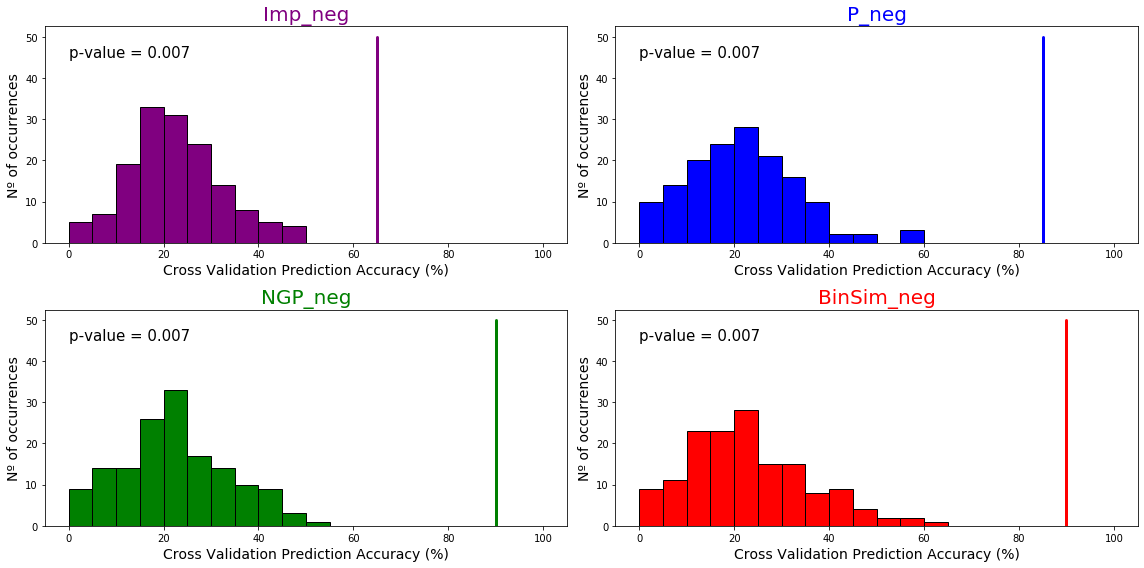

In [110]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'BinSim_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, color):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(0,45, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

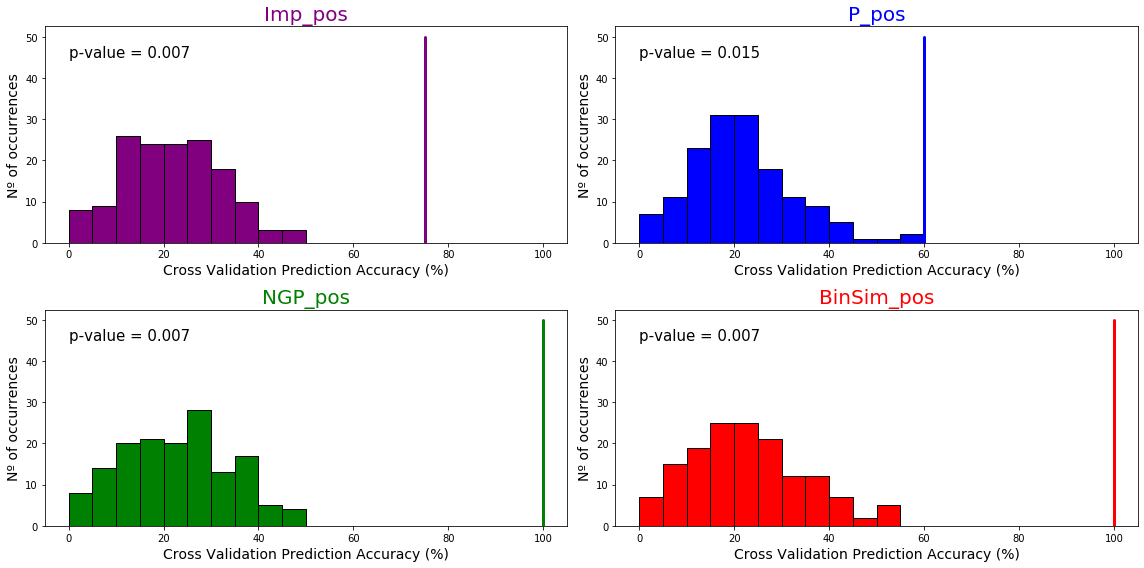

In [111]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_pos', 'P_pos', 'NGP_pos', 'BinSim_pos']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, color):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(0,45, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()